# 1. MediaPipe

## Instalação das bibliotecas

In [1]:
!pip install opencv-python==4.6.0.66
!pip install mediapipe==0.8.11
!pip install numpy==1.22.3


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import cv2
import mediapipe as mp
import numpy as np
import time

Objetos usados para identificar a face

In [6]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

## Lendo a webcam

Os parâmetros, **min_detection_confidence** e **min_tracking_confidence**, especificam, respectivamente, o valor mínimo de confiança de detecção da face e o valor mínimo de confiança para o rastreamento dos pontos na face. Podemos parametrizar o valor de confiança entre 0.0 e 1.0. O valor padrão para ambos é 0.5.

In [9]:
# Instancia a leitura da webcam principal
cap = cv2.VideoCapture(0)


with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as facemesh:
    while cap.isOpened():
        # lê a webcam
        sucesso, frame = cap.read()

        if not sucesso:
            print("Ignorando o frame vazio da câmera.")
            continue


        # Captura as marcações da face
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        saida_facemesh = facemesh.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)


        # o Try é usado pois se não houver rostos o programa irá gerar um erro
        try:
            # Marcação dos pontos faciais encontrados
            for face_landmarks in saida_facemesh.multi_face_landmarks:
                mp_drawing.draw_landmarks(frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, 
                                          landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255, 102, 102), thickness=1, circle_radius=1),
                                          connection_drawing_spec = mp_drawing.DrawingSpec(color=(102,204,0),thickness=1,circle_radius=1))
        except:
            pass


        # Mostra o frame lido da webcam
        cv2.imshow("Camera", frame)

        # interrompe o while quando o 'c' é apertado
        if cv2.waitKey(10) & 0xFF == ord('c'):
            break

# solta a webcam e fecha as janelas abertas
cap.release()
cv2.destroyAllWindows()

# 2. Mapeando os Olhos

onde encontrar as coordenadas da face

In [10]:
for face_landmarks in saida_facemesh.multi_face_landmarks:
    face = face_landmarks
    for id_coord, coord_xyz in enumerate(face.landmark):
        print(coord_xyz)

x: 0.54542076587677
y: 0.7720795273780823
z: -0.015340347774326801

x: 0.5406135320663452
y: 0.7317795753479004
z: -0.04324417561292648

x: 0.542910099029541
y: 0.7414693832397461
z: -0.019245147705078125

x: 0.5318350195884705
y: 0.6905970573425293
z: -0.03772104158997536

x: 0.5395987629890442
y: 0.7198821902275085
z: -0.04772654175758362

x: 0.5389109253883362
y: 0.7029232978820801
z: -0.04681892693042755

x: 0.537986695766449
y: 0.6599971652030945
z: -0.03155364841222763

x: 0.48338809609413147
y: 0.6578078269958496
z: 0.004923504777252674

x: 0.5366829633712769
y: 0.6313435435295105
z: -0.03134544566273689

x: 0.5356793999671936
y: 0.6153494119644165
z: -0.036229152232408524

x: 0.5323359370231628
y: 0.5535855293273926
z: -0.03799140825867653

x: 0.5460036993026733
y: 0.777955174446106
z: -0.013280523009598255

x: 0.5466282367706299
y: 0.7814129590988159
z: -0.009704220108687878

x: 0.5471153259277344
y: 0.7819026708602905
z: -0.005394045729190111

x: 0.5476213693618774
y: 0.78443

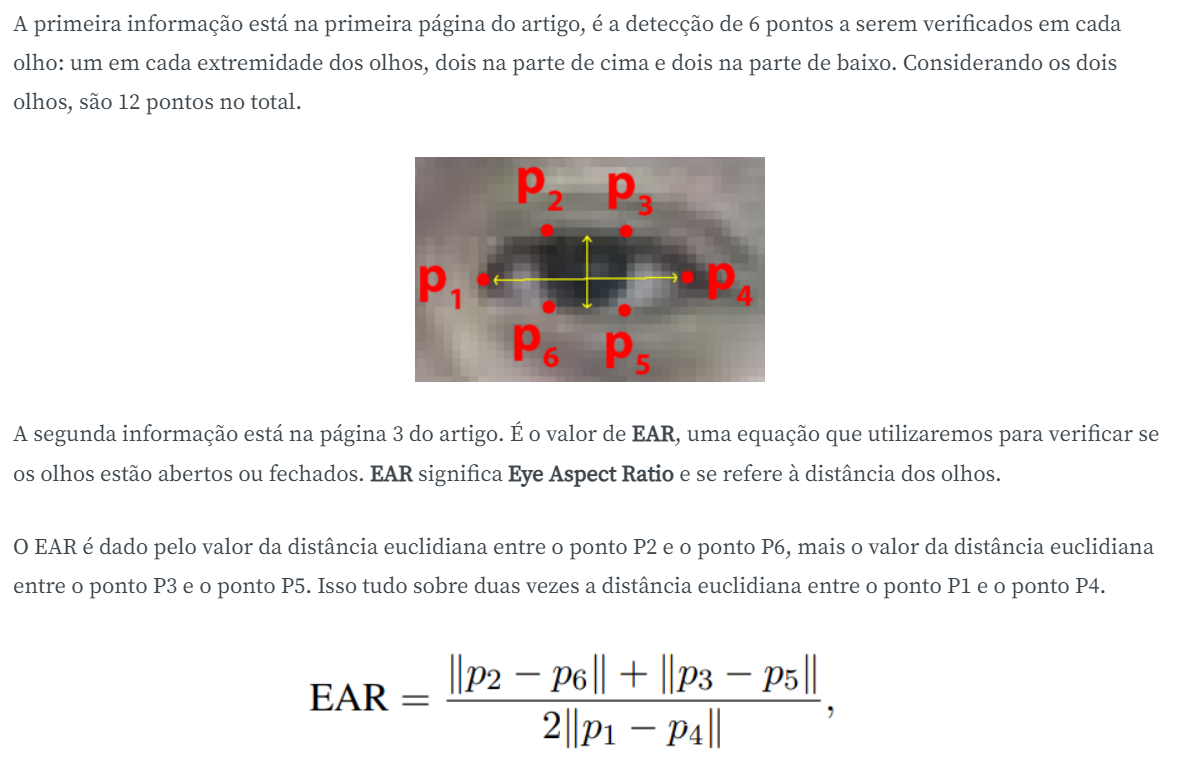

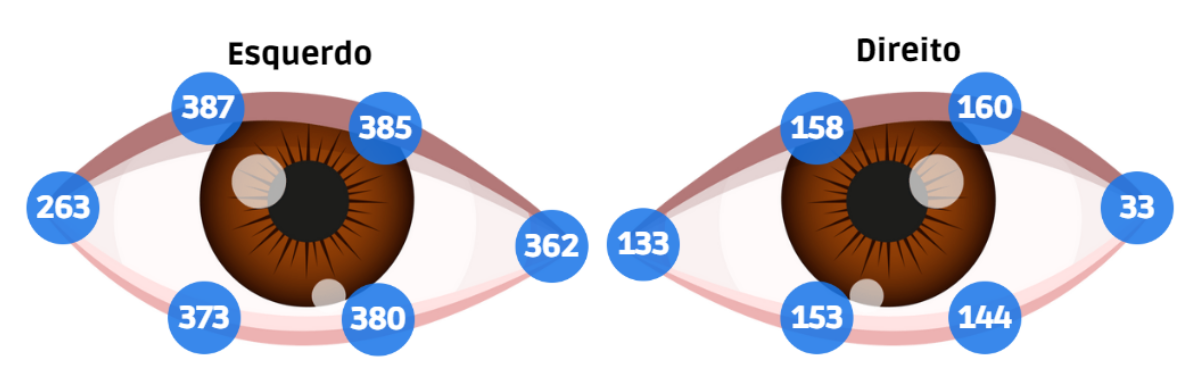

In [11]:
p_olho_esq = [385, 380, 387, 373, 362, 263]
p_olho_dir = [160, 144, 158, 153, 33, 133]


In [14]:
p_olhos = p_olho_esq+p_olho_dir
p_olhos


[385, 380, 387, 373, 362, 263, 160, 144, 158, 153, 33, 133]

In [18]:
def calculo_ear(face, p_olho_dir, p_olho_esq):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])

        face_esq = face[p_olho_esq, :]
        face_dir = face[p_olho_dir, :]

        ear_esq = (np.linalg.norm(face_esq[0]-face_esq[1])+np.linalg.norm(face_esq[2]-face_esq[3]))/(2*(np.linalg.norm(face_esq[4]-face_esq[5])))
        ear_dir = (np.linalg.norm(face_dir[0]-face_dir[1])+np.linalg.norm(face_dir[2]-face_dir[3]))/(2*(np.linalg.norm(face_dir[4]-face_dir[5])))
    except:
        ear_esq = 0.0
        ear_dir = 0.0
    
    media_ear = (ear_esq+ear_dir)/2
    return media_ear

os pontos precisam estar em pixels, porém eles vem normalizados.  
Então será necessário transformar para pixels!

In [32]:
ear_limiar = 0.38
dormindo = 0

mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

cap = cv2.VideoCapture(0)


with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as facemesh:
    while cap.isOpened():
        sucesso, frame = cap.read()
        if not sucesso:
            print("Ignorando o frame vazio da câmera.")
            continue

        comprimento, largura, _ = frame.shape

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        saida_facemesh = facemesh.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        try:
            for face_landmarks in saida_facemesh.multi_face_landmarks:
                mp_drawing.draw_landmarks(frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, 
                                          landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255, 102, 102), thickness=1, circle_radius=1),
                                          connection_drawing_spec = mp_drawing.DrawingSpec(color=(102,204,0),thickness=1,circle_radius=1))
                
                face = face_landmarks.landmark
                for id_coord, coord_xyz in enumerate(face):
                    # identifica os pontos dos olhos e pinta eles de azul
                    if id_coord in p_olhos:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x,coord_xyz.y, largura, comprimento)
                        cv2.circle(frame, coord_cv, 2, (255,0,0), -1)

                # calcula o ear para esta face
                ear = calculo_ear(face, p_olho_dir, p_olho_esq)
                # apresenta na tela o valor do EAR
                cv2.rectangle(frame, (0,1),(290,140),(58,58,55),-1)
                cv2.putText(frame, f"EAR: {round(ear, 2)}", (1, 24),
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (255, 255, 255), 2)
    
                
                # contando o tempo que o olho ficou fechado
                if ear < ear_limiar:
                    t_inicial = time.time() if dormindo == 0 else t_inicial
                    dormindo = 1

                if dormindo == 1 and ear >= ear_limiar:
                    dormindo = 0

                t_final = time.time()
    
                # calcula o tempo de olho fechado
                tempo = (t_final - t_inicial) if dormindo == 1 else 0.0

                cv2.putText(frame, f"Tempo: {round(tempo, 3)}", (1, 80),
                                        cv2.FONT_HERSHEY_DUPLEX,
                                        0.9, (255, 255, 255), 2)

                # gera alerta se ficar de olho fechado por mais de x segundos
                if tempo >= 1.5:
                    cv2.rectangle(frame, (30, 400), (610, 452), (109, 233, 219), -1)
                    cv2.putText(frame, f"Muito tempo com olhos fechados!", (80, 435),
                                    cv2.FONT_HERSHEY_DUPLEX,
                                    0.85, (58,58,55), 1)

        except:
            pass

        cv2.imshow("Camera", frame)

        if cv2.waitKey(10) & 0xFF == ord('c'):
            break

cap.release()
cv2.destroyAllWindows()